# YOUR PROJECT TITLE

Imports and set magics:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
from dataproject import NyboligScraper
from dataproject import NyboligAnalysis


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scraping data

First we need to scrape the data from the internet. The data is scraped from https://www.nybolig.dk/. To know how many pages is possible to scrape you can call the get_pages function of the following property types:

**All**: ''
**Andelsbolig**: 'andelsbolig'
**Ejerlejlighed**: 'ejerlejlighed'
**Sommerhusgrunde**: 'fritidsgrund'
**Grunde**: 'helaarsgrund'
**Hus**: 'hus'
**Landejendomme**: 'landejendom'
**Rækkehuse**:  'raekkehus'
**Sommerhuse**: 'sommerhus'
**Villalejligheder**:   'villalejlighed'


The number of pages that you choose will determine the size of the dataset.

In [14]:
scraper = NyboligScraper()
scraper.get_pages(property_type='')


Total number of pages: 2222


Next, we need to identify what property types and how many pages we want to work with. To do this you can call the scraper.scrape_data_nybolig(self, num_pages, property_type=None, file_name=None) function. This will save the desired data into a CSV file that we will be able to work with.

In [15]:
scraper.scrape_data_nybolig(num_pages=5, property_type='sommerhus', file_name='dataprojekt_data')

# Accessing Data

Now that we have created the dataset we need to access it. To do this please provide the path of this dictionary with the filename.

In [39]:
file_path = 'dataprojekt_data.csv'
data = pd.read_csv('dataprojekt_data.csv')
print(data.head())


                                             address postcode      city  \
0  Egil Fischers Vej 14, Femmøller Strand, 8400 E...     8400  Ebeltoft   
1       Nørre Knoldevej 27, Skal Klit, 9800 Hjørring     9800  Hjørring   
2       Sellerup Strandvej 79, Sellerup, 7080 Børkop     7080    Børkop   
3                       Vandflodvej 25, 6857 Blåvand     6857   Blåvand   
4                 Grindevej 14, Ulstrup, 9480 Løkken     9480    Løkken   

     price          type  rooms  size_1  size_2  
0  5500000  Fritidsbolig      4     177   114.0  
1  5400000  Fritidsbolig      8     150     NaN  
2  5495000  Fritidsbolig      4     144     NaN  
3  3395000  Fritidsbolig      5     178     NaN  
4  1998000  Fritidsbolig      5     128     NaN  


# Analysis

In [40]:
analysis = NyboligAnalysis(file_path)

In [41]:
analysis.descriptive_statistics('price')

,count,mean,std,min,25%,50%,75%,max
price,100,2395560.0,2.128011e+06,545000,1295000.0,1895000.0,2756250.0,17000000


# Multiple Linear Regression, MLR

With this regression on property prices we will investigate how number of rooms, size_1 and size_2 affects the price. Therefore we have property prices as the dependent variable and these common features as the independent variables.

In [42]:
# Importing the libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [43]:
# Loading the data

data = pd.read_csv('dataprojekt_data.csv')
data = data.dropna(subset=['price', 'size_1', 'rooms'])

In [44]:
# Creating our dependent and independent variables, Y and X

X = data[['size_1', 'rooms']]
y = data['price']

In [45]:
# Splitting data into training and test sets, 80% of the data in training and 20% in tests


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Fitting the linear regression model to the training data data

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [47]:
# Now we use the fitted model to make predictions on the test set

y_pred = model.predict(X_test)

In [48]:
# For evaluation of the model we calculate (MSE) and (R² score):

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² score: {r2:.2f}')

Mean Squared Error: 1469584848446.63
R² score: 0.58


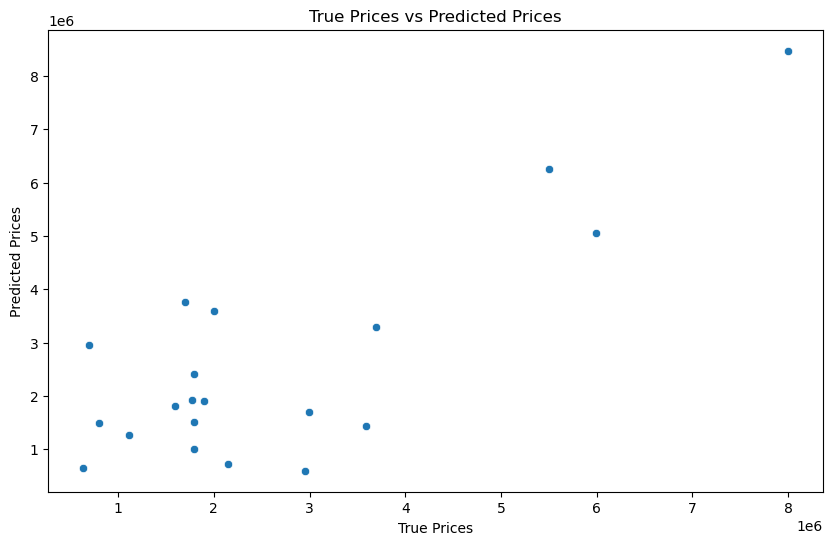

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True Prices vs Predicted Prices')
plt.show()


In [1]:
#Anden tilgang til MLR - lidt mere forsimplet
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

file_path = 'dataprojekt_data.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['price', 'size_1', 'rooms'])

X = data[['size_1', 'rooms']]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant term to the independent variables matrix for the intercept
X_train = sm.add_constant(X_train)

# Fit the OLS model
model = sm.OLS(y_train, X_train).fit()


In [51]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     46.09
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           6.89e-14
Time:                        18:18:04   Log-Likelihood:                -1249.3
No. Observations:                  80   AIC:                             2505.
Df Residuals:                      77   BIC:                             2512.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.405e+05   5.39e+05     -1.189      0.2